## Quantifying a Spectrum

#### Note:  This notebook uses some archaic syntax that is not necessary if the `reference` and `references` functions are used to build the fitting standards.

This script show how to pull together the functionality in the NeXL X-ray microanalysis library to quantify a electron-excited X-ray spectrum using standard spectra.

First, we need to load the necessary libraries - `NeXLSpectrum` and `NeXLMatrixCorrection` from NeXL, `Gadfly` for plotting and `DataFrames` for tabulation. 

In [1]:
using NeXLSpectrum
using NeXLMatrixCorrection
using Gadfly
using DataFrames

┌ Info: Loading Gadfly support into NeXLSpectrum.
└ @ NeXLSpectrum c:\Users\nicho\.julia\dev\NeXLSpectrum\src\gadflysupport.jl:792


Next we specify where the spectra are located and load the spectrum from a file.  `loadspectrum(...)` can sniff the format of a spectrum file and load 'ISO/EMSA', 'ASPEX TIFF' and 'Bruker SPX' files automatically.

Once the spectrum is loaded into `unk`, we use the data in `unk` to build a suitable detector with a FWHM at Mn K$\alpha$ of 132.0 eV and a low-level discriminator cut-off of 120 channels.  Finally, we set the `:Detector` property of the spectrum to `det`.

Finally, we use `Gadfly`, which `NeXLSpectrum` has specialized to understand `Spectrum` structures, to plot the spectrum with KLM markers from 0.0 eV to 8,000 eV.

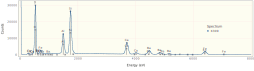

In [2]:
path = "K309"
unk = loadspectrum(joinpath(path,"K309.msa"))
det = matching(unk, 132.0, 120)
unk[:Detector] = det
set_default_plot_size(10inch,2.8inch)
plot(unk, klms=[n"O", n"Al", n"Si", n"Ca", n"Fe", n"Ba"], xmax=8.0e3)

Next, we define and load the reference spectra.  Here we use `n".."` notation to parse the element symbol and `mat"..."` to parse the composition.

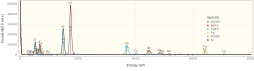

In [3]:
refs = ( 
    ( n"O", "Al2O3 std.msa", mat"Al2O3" ),
    ( n"Al", "Al2O3 std.msa", mat"Al2O3" ),
    ( n"Si", "Si std.msa", mat"Si" ),
    ( n"Ca", "CaF2 std.msa", mat"CaF2" ),
    ( n"Fe", "Fe std.msa", mat"Fe" ),
    ( n"Ba", "BaF2 std.msa", mat"BaF2" )
)
refspecs = Dict()
for (elm, file, comp) in refs
    spec = loadspectrum(joinpath(path,file))
    spec[:Detector] = det
    spec[:Composition] = comp
    refspecs[elm] = spec
end
plot(values(refspecs)..., autoklms=true, xmax=8.0e3, norm=ScaleDose())

To perform a top-hat filter-fit, we must first filter the reference spectra.  Each spectrum can contribute one or more `Reference[..]` datums depending upon how many contiguous regions of channels are represented by the element for which the spectrum is a reference.

`buildfilter(...)` builds the matrix which represents the top-hat filter.

`filterreference(...)` applies the filter to the reference spectrum. In this case it creates 8 `Reference[...]` structures for 6 elements.

In [4]:
filt = buildfilter(det)
frs = mapreduce(append!, keys(refspecs)) do elm
    filterreference(filt, refspecs[elm], elm, refspecs[elm][:Composition])
end

┌ Info: A material containing Ba and F is not a suitable reference for "Ba M5-N3 + 16 others" due to a peak interference.
└ @ NeXLSpectrum c:\Users\nicho\.julia\dev\NeXLSpectrum\src\filter.jl:423


8-element Vector{FilteredReference{Float64}}:
 Reference[k[Al K-L3 + 3 others, Al2O3]]
 Reference[k[Ba L3-M5 + 29 others, BaF2]]
 Reference[k[Ca K-L3 + 3 others, CaF2]]
 Reference[k[Fe L3-M5 + 13 others, Fe]]
 Reference[k[Fe K-L3 + 1 other, Fe]]
 Reference[k[Fe K-M3 + 3 others, Fe]]
 Reference[k[O K-L3 + 1 other, Al2O3]]
 Reference[k[Si K-L3 + 3 others, Si]]

In [13]:
using BenchmarkTools
@benchmark extract($frs[1], $frs[1].ffroi)

BenchmarkTools.Trial: 10000 samples with 870 evaluations.
 Range (min … max):  127.471 ns …   4.120 μs  ┊ GC (min … max):  0.00% … 94.02%
 Time  (median):     141.379 ns               ┊ GC (median):     0.00%
 Time  (mean ± σ):   195.619 ns ± 237.995 ns  ┊ GC (mean ± σ):  15.27% ± 12.37%

  █▄▃▂▂▁▁                                                       ▁
  █████████▇█▇▇█▇▆▆▅▅▅▅▇██▆▃▄▅▃▄▃▁▃▁▁▄▁▃▁▁▃▁▁▅▄▁▁▁▁▁▁▃▁▁▁▁▅▇█▇▇ █
  127 ns        Histogram: log(frequency) by time       1.52 μs <

 Memory estimate: 1.06 KiB, allocs estimate: 1.

Finally, we apply the filter to the unknown and fit the filtered references.  The `false` says that negative k-ratios should not be set to zero and the fit repeated with that element removed.

The results are tabulated as a `DataFrame`

In [5]:
ENV["LINES"] = 60; ENV["COLUMNS"]=120
res=fit_spectrum(unk, filt, frs, false)
asa(DataFrame,res)

Row,Spectrum,Feature,Reference,K,dK,Counts,RefCountsPernAs,CountsPernAs
,UnknownL…,CharXRay…,String,Float64,Float64,Float64,Float64,Float64
1,K309,"k[Al K-L3 + 3 others, Al2O3]",Al2O3,0.122069,0.000257139,1.79346e5,6300.17,769.056
2,K309,"k[Ba L3-M5 + 29 others, BaF2]",BaF2,0.140262,0.000494682,92960.2,2842.0,398.625
3,K309,"k[Ca K-L3 + 3 others, CaF2]",CaF2,0.205912,0.000417266,1.69882e5,3537.78,728.473
4,K309,"k[Fe K-L3 + 1 other, Fe]",Fe,0.0886529,0.000363907,48163.7,2329.67,206.532
5,K309,"k[Fe K-M3 + 3 others, Fe]",Fe,0.0909041,0.0016223,6663.85,314.347,28.5754
6,K309,"k[Fe L3-M5 + 13 others, Fe]",Fe,0.0587816,0.000588315,32819.5,2394.18,140.734
7,K309,"k[O K-L3 + 1 other, Al2O3]",Al2O3,0.636479,0.000823497,3.41602e5,2301.46,1464.83
8,K309,"k[Si K-L3 + 3 others, Si]",Si,0.139227,0.000175346,4.25431e5,13103.0,1824.3


To visualize these results, `Gadfly` has been specialized to plot `FilterFitResult` objects like this.  The plot shows the range of channels involved in each fitted ROI along with the associated k-ratio.  The red line is the filter fit residual.  It shows which x-rays were not accounted for as characteristic X-rays in one of the references.  You can use the residual to determine if any elements have been overlooked.

You can see that some of the ROIs are narrow (like the O K) while others are broad (like the Ba L). You can also see which ROIs interfere with each other (like the O K and Fe L or the Al K and Si K).

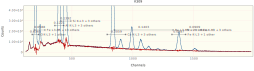

In [6]:
plot(res)

The final step is to take the k-ratios and use iteration to estimate the composition.

In [9]:
ENV["LINES"] = 60; ENV["COLUMNS"]=200
iterres = quantify(res, iteration = Iteration(mc=XPP, fc=ReedFluorescence, cc=NullCoating))
asa(DataFrame, iterres)

Row,Label,Element,Standard,Xrays,C,ΔC,k,Δk,g,Z,A,F,c,gZAFc
,String,String,String,String,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,K309,Al,Al2O3,Al K-L3 + 3 others,0.075503,0.00016,0.122069,0.000257139,1.0,1.06118,0.800934,1.00674,1.0,0.85566
2,K309,Ba,BaF2,Ba L3-M5 + 29 others,0.14042,0.0005,0.140262,0.000494682,1.0,0.77039,1.01169,1.0039,1.0,0.782439
3,K309,Ca,CaF2,Ca K-L3 + 3 others,0.10732,0.00022,0.205912,0.000417266,1.0,1.01122,0.962424,1.01204,1.0,0.984942
4,K309,Fe,Fe,Fe K-L3 + 1 other,0.10359,0.00043,0.0886529,0.000363907,1.0,0.874544,0.978625,1.0,1.0,0.855851
5,K309,O,Al2O3,O K-L3 + 1 other,0.38992,0.0005,0.636479,0.000823497,1.0,1.06014,0.725265,0.999393,1.0,0.768417
6,K309,Si,Si,Si K-L3 + 3 others,0.18268,0.00023,0.139227,0.000175346,1.0,1.02674,0.741544,1.00098,1.0,0.76212


In [10]:
asa(DataFrame, [ iterres.comp ])

Row,Material,O,Al,Si,Ca,Fe,Ba,Total
,String,Abstract…,Abstract…,Abstract…,Abstract…,Abstract…,Abstract…,Abstract…
1,K309,0.389922,0.0755033,0.182683,0.107318,0.103585,0.140415,9.994272e-01 ± 0.0e+00
